# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import optuna

from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="'verbose' argument is deprecated.*")

### Path management

In [2]:
base: str
if os.getcwd() == "/kaggle/working":
    base = "/kaggle"
else:
    base = os.path.join(os.getcwd())

def get_full_dir(sub_dir: str) -> str:
    return os.path.join(base, sub_dir)

# EDA

In [3]:
df_sample_submission: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e16/sample_submission.csv'))
df_train: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e16/train.csv'), index_col='id')
df_test: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e16/test.csv'), index_col='id')
df_og: pd.DataFrame = pd.read_csv(get_full_dir('input/crab-age-prediction/CrabAgePrediction.csv'))

In [4]:
df_train.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

In [5]:
df_test.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
dtype: int64

In [6]:
df_og.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

##### No missing value, does not hurt to check

In [7]:
df_sample_submission.head()

,id,Age
0,74051,10
1,74052,10
2,74053,10
3,74054,10
4,74055,10


##### We simple predicting age for each crab

In [8]:
df_train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
id,,,,,,,,,
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [9]:
df_test.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
id,,,,,,,,
74051,I,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
74052,I,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
74053,F,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
74054,F,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
74055,I,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066


In [10]:
df_og.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


In [11]:
df_train.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806
std,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


In [12]:
df_test.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
count,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000
mean,1.319795,1.026357,0.348693,23.464627,10.130220,5.072615,6.745876
std,0.286950,0.236593,0.092259,12.641703,5.611779,2.791563,3.575650
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524
25%,1.162500,0.887500,0.300000,13.536886,5.740774,2.877474,3.968930
50%,1.387500,1.075000,0.362500,23.813580,9.979024,4.989512,6.945627
75%,1.537500,1.200000,0.412500,32.290081,14.047177,7.016501,9.171063
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248


In [13]:
df_og.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000
mean,1.311306,1.020893,0.349374,23.567275,10.207342,5.136546,6.795844,9.954791
std,0.300431,0.248233,0.104976,13.891201,6.275275,3.104133,3.943392,3.220967
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000
25%,1.125000,0.875000,0.287500,12.672227,5.343881,2.664853,3.713785,8.000000
50%,1.362500,1.062500,0.362500,22.792998,9.539607,4.861939,6.662133,10.000000
75%,1.537500,1.200000,0.412500,32.786197,14.273973,7.200773,9.355335,11.000000
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


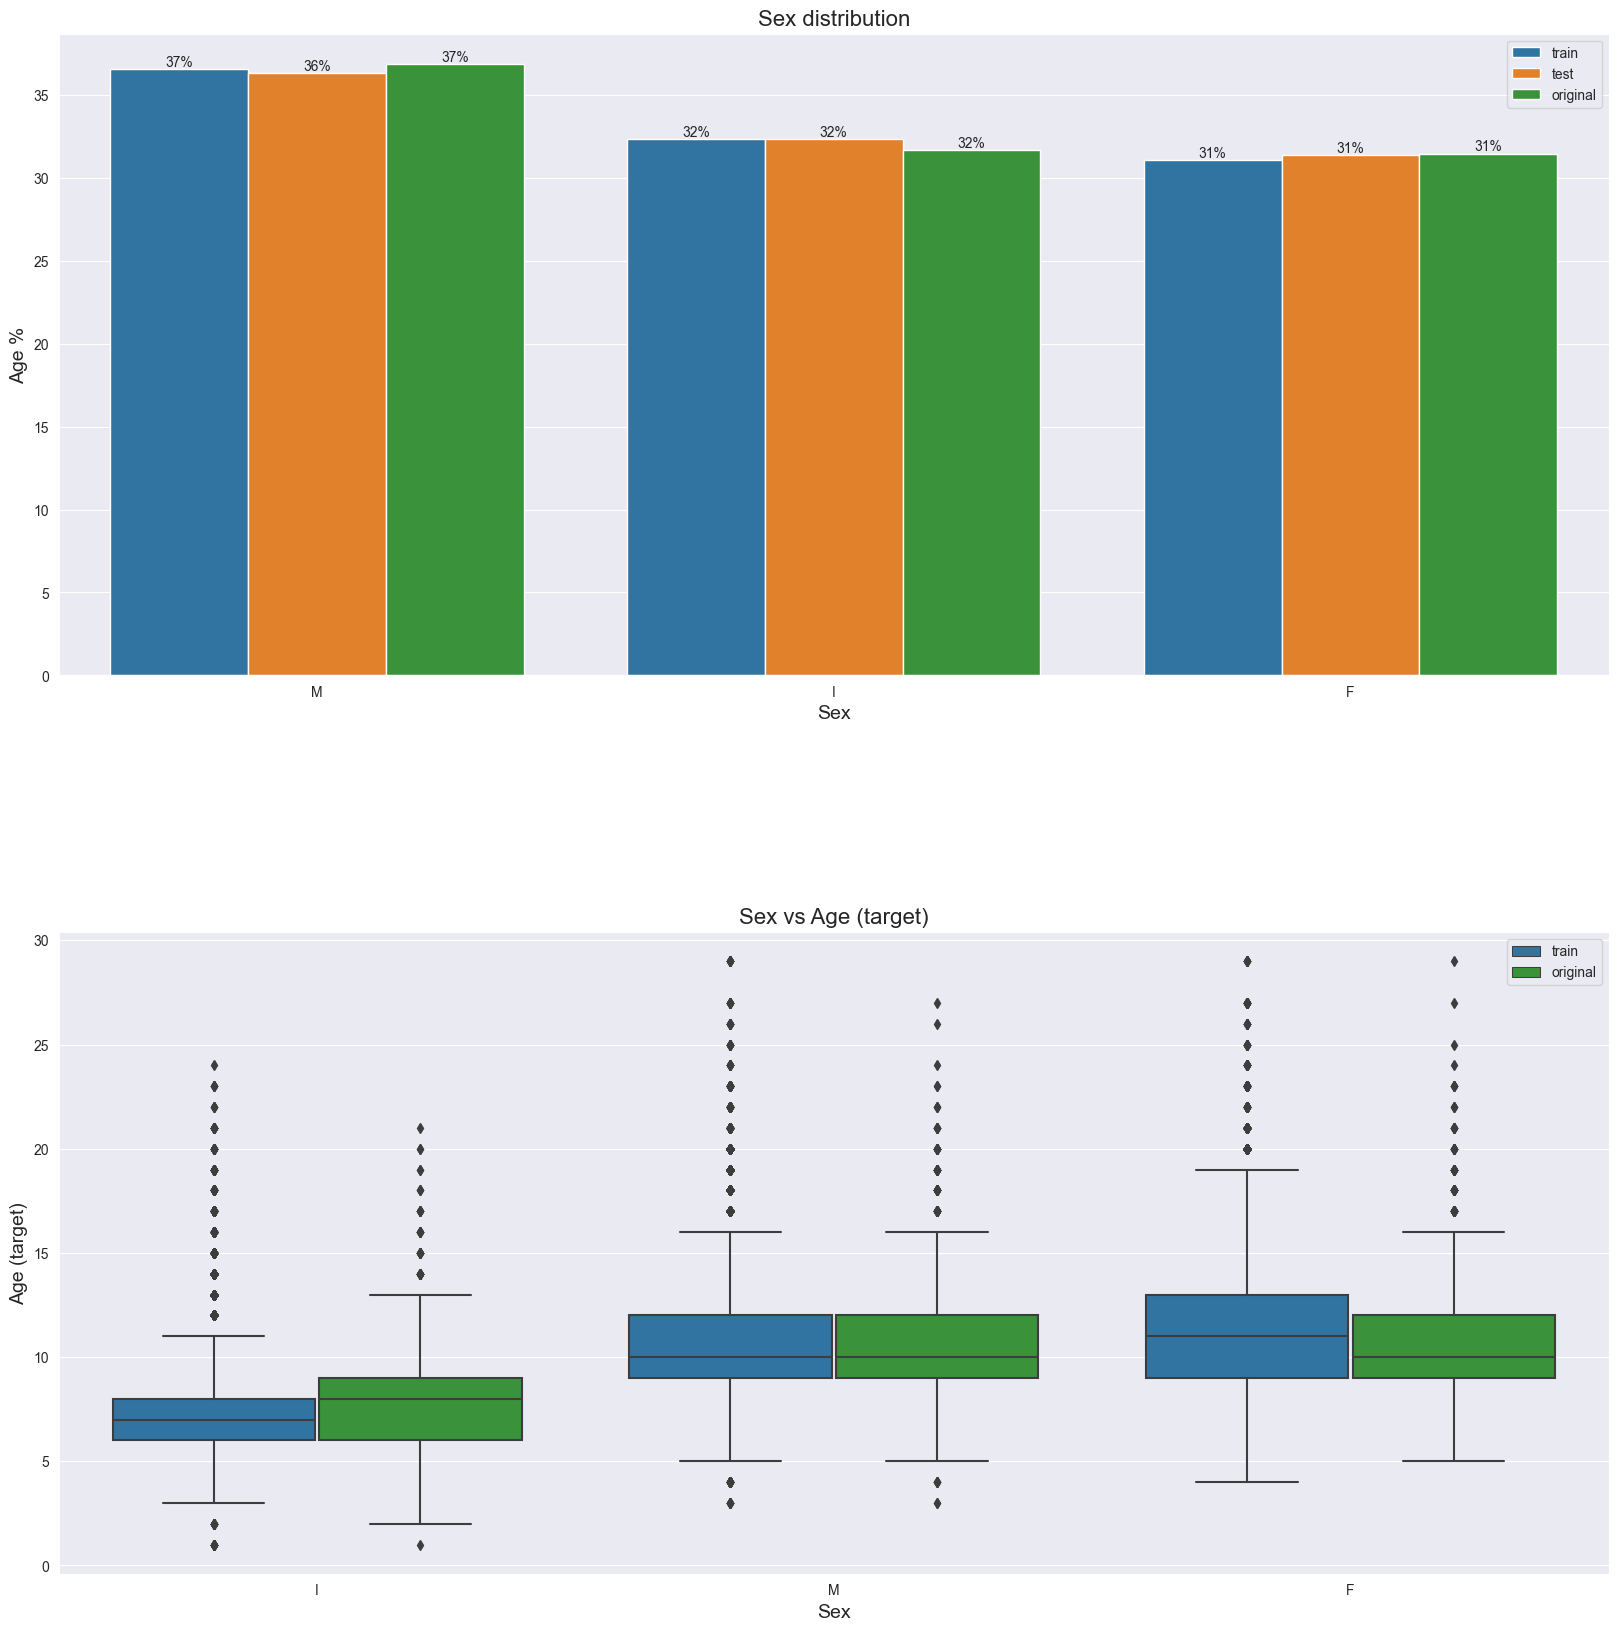

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axes = axes.flatten()

def graph_categorical_feature(data: list[tuple[pd.DataFrame, str, str]], target: str, axes_start_i: int,
                              x_label: list[str] = ('x', 'x'), y_label: list[str] = ('y', 'y'), title: list[str]=None, colors: list[str] = None) -> None:

    # Plot barplots
    df_tmp = pd.DataFrame({})
    for df, column, label in data:
        df_tmp_local = pd.DataFrame(df[column].value_counts() * 100 / df[column].count())
        df_tmp_local['dataset'] = label
        df_tmp = pd.concat([df_tmp, df_tmp_local], axis=0)
    df_tmp['x'] = df_tmp.index
    df_tmp = df_tmp.rename(columns={column: 'y', 'dataset': 'Data Set'})
    sns.barplot(data=df_tmp, y='y', x="x", hue="Data Set", orient='v', ax=axes[axes_start_i])
    #axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    for p in axes[i].patches:
        axes[i].annotate(format(p.get_height(), '.0f') + '%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 5),
                    textcoords = 'offset points')
    axes[axes_start_i].set_xlabel(x_label[0], fontsize=14)
    axes[axes_start_i].set_ylabel(y_label[0], fontsize=14)
    if title is not None:
        axes[axes_start_i].set_title(title[0], fontsize=16)

    df_tmp = pd.DataFrame({})
    for df, column, label in data:
        if label != 'test':
            df_tmp_local = df.loc[:, [column, target]]
            df_tmp_local['dataset'] = label
            df_tmp = pd.concat([df_tmp, df_tmp_local], axis=0)
    df_tmp = df_tmp.rename(columns={column: 'c', 'dataset': 'Data Set'})
    if colors is not None:
        sns.boxplot(x='c', y=target, data=df_tmp, orient='v', hue="Data Set", ax=axes[axes_start_i + 1], palette=colors)
    else:
        sns.boxplot(x='c', y=target, data=df_tmp, orient='v', hue="Data Set", ax=axes[axes_start_i + 1])
    axes[axes_start_i + 1].set_xlabel(x_label[1], fontsize=14)
    axes[axes_start_i + 1].set_ylabel(y_label[1], fontsize=14)
    if title is not None:
        axes[axes_start_i + 1].set_title(title[1], fontsize=16)

    # Plot legends
    axes[axes_start_i].legend()
    axes[axes_start_i + 1].legend()

i = 0
graph_categorical_feature([(df_train, 'Sex', 'train'), (df_test, 'Sex', 'test'), (df_og, 'Sex', 'original')], 
                          'Age', i, 
                          x_label=['Sex', 'Sex'], 
                          y_label=['Age %', 'Age (target)'], 
                          title=['Sex distribution', 'Sex vs Age (target)'], 
                          colors=[sns.color_palette("tab10")[0], sns.color_palette("tab10")[2]])
plt.show()

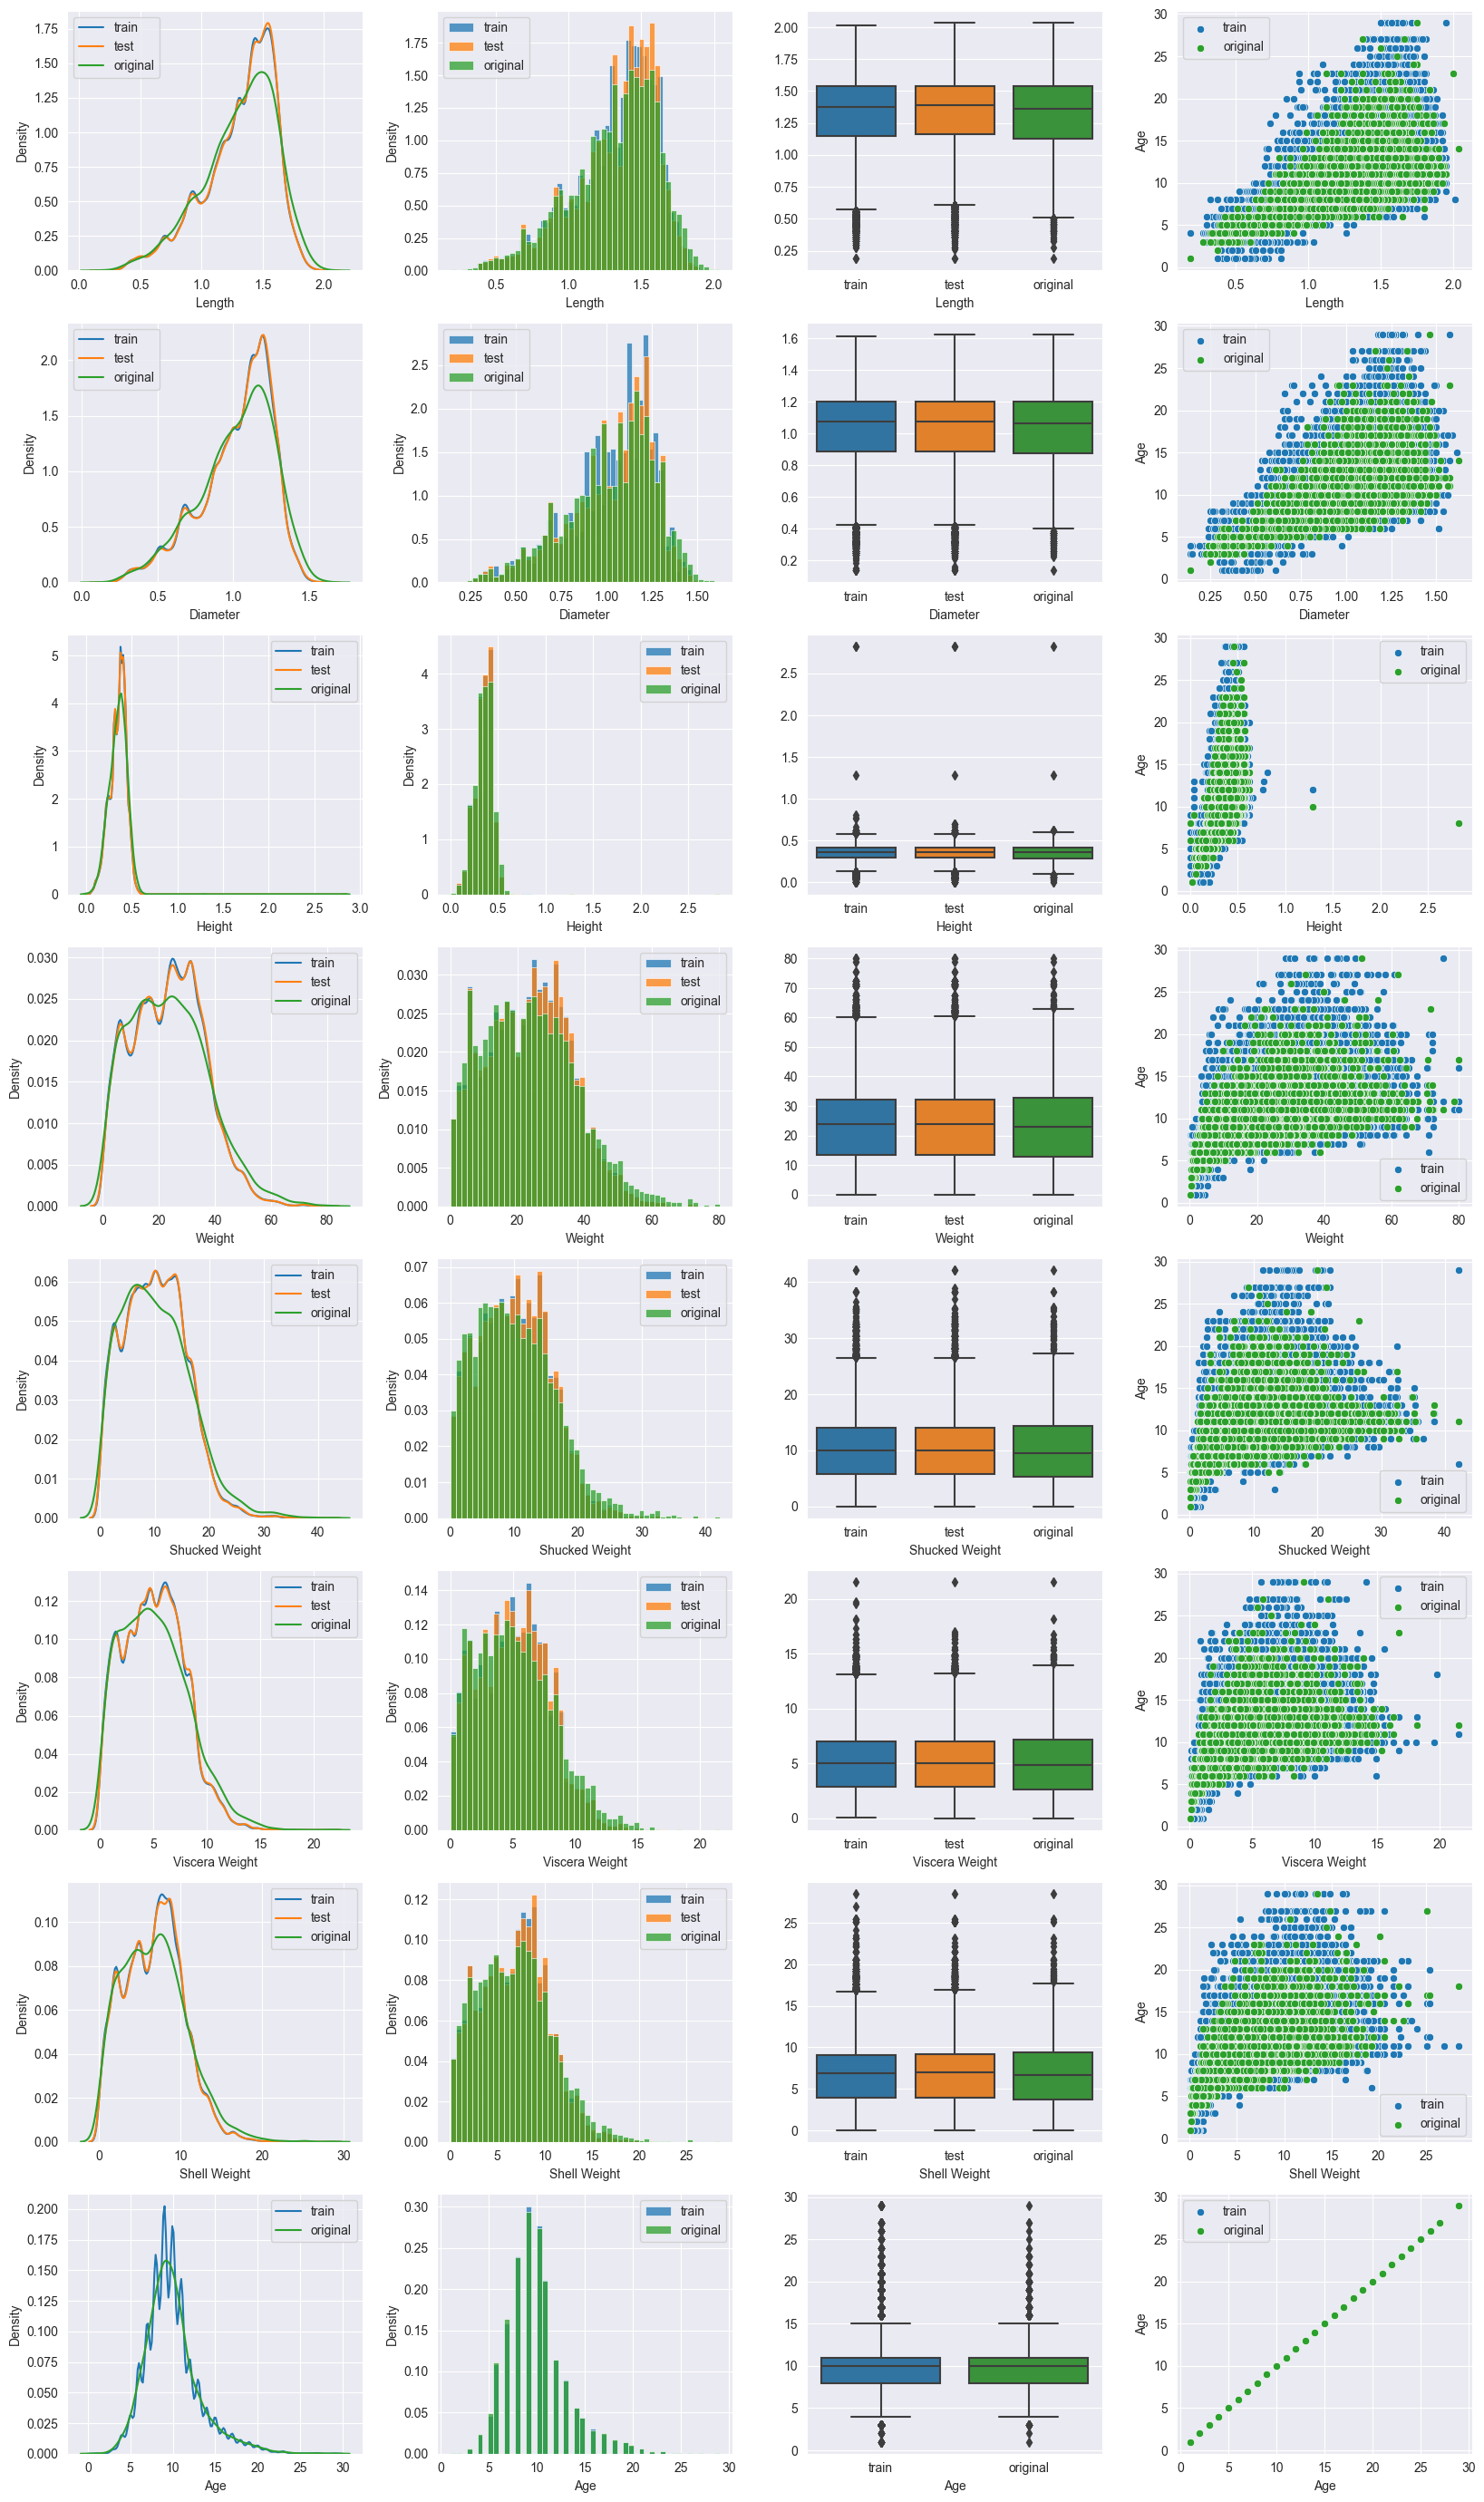

In [15]:
fig, axes = plt.subplots(nrows=len(df_train.columns) - 1, ncols=4, figsize=(20, 35))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
axes = axes.flatten()

def graph_numerical_feature(data: list[tuple[pd.DataFrame, str, str]], target: str, axes_start_i: int, palette=sns.color_palette("tab10")) -> None:
    # Plot densities
    for e, cd in enumerate(data):
        df, column, label = cd
        sns.kdeplot(df[column], label=label, ax=axes[axes_start_i], fill=False, color=palette[e])
    for e, cd in enumerate(data):
        df, column, label = cd
        sns.histplot(df[column], label=label, ax=axes[axes_start_i + 1], stat="density", bins=50, color=palette[e])

    # Plot boxplot
    tmp_data_dict = {}
    for df, column, label in data:
        tmp_data_dict[label] = df[column]
    df_tmp = pd.DataFrame(tmp_data_dict)
    sns.boxplot(data=df_tmp, ax=axes[axes_start_i + 2], palette=palette)
    axes[axes_start_i + 2].set_xlabel(col)

    # Plot target correlation
    for e, cd in enumerate(data):
        df, column, label = cd
        if label != 'test':
            sns.scatterplot(x=column, y=target, label=label, ax=axes[axes_start_i + 3], data=df, color=palette[e])

    # Plot legends
    axes[axes_start_i].legend()
    axes[axes_start_i + 1].legend()
    axes[axes_start_i + 3].legend()

i = 0
for col in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[col]):
        if col != 'Age':
            graph_numerical_feature([(df_train, col, 'train'), (df_test, col, 'test'), (df_og, col, 'original')], 'Age', i)
            i += 4
graph_numerical_feature([(df_train, 'Age', 'train'), (df_og, 'Age', 'original')], 'Age', i, palette=[sns.color_palette("tab10")[0], sns.color_palette("tab10")[2]])
plt.show()

##### The original data closely follows the distribution of our given synthetic data.

In [16]:
age_range = df_train['Age'].max() - df_train['Age'].min()
age_uniqe_values = df_train['Age'].nunique()
print(f'Age Range: {age_range} Uniq Ages: {age_uniqe_values}')

Age Range: 28 Uniq Ages: 28


##### The age density grpah needs to have its bin count adjusted

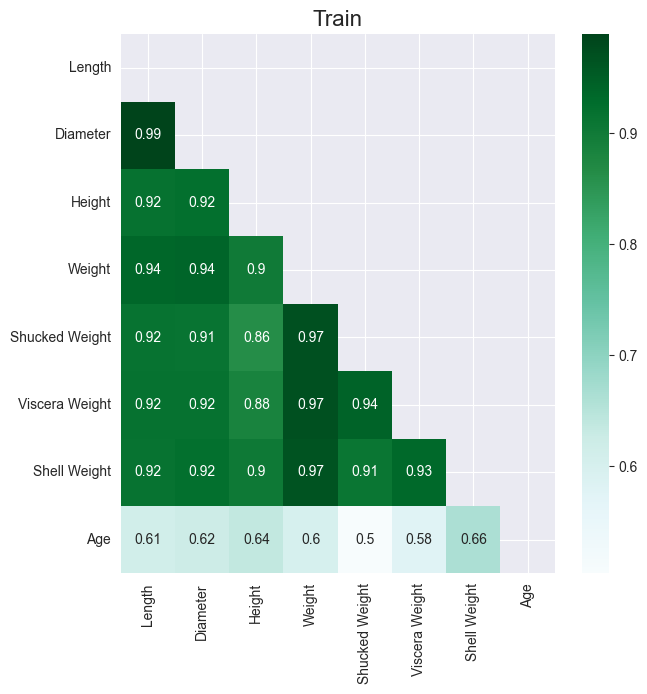

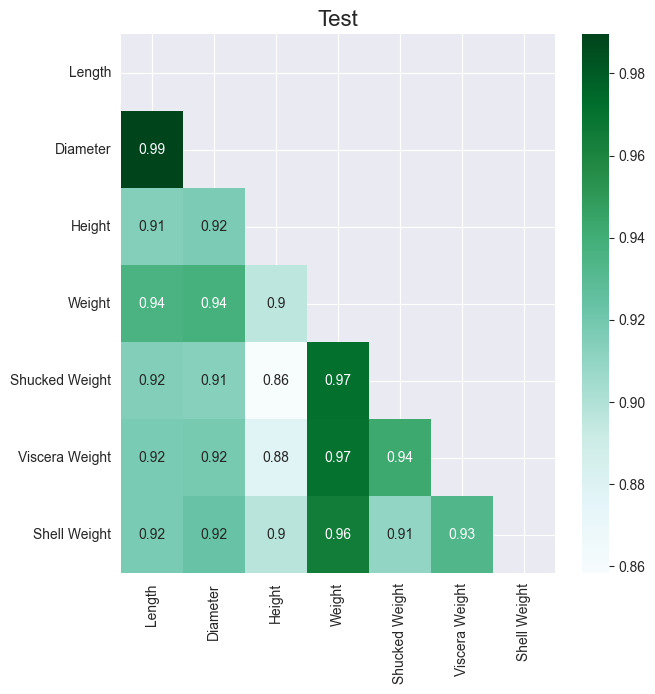

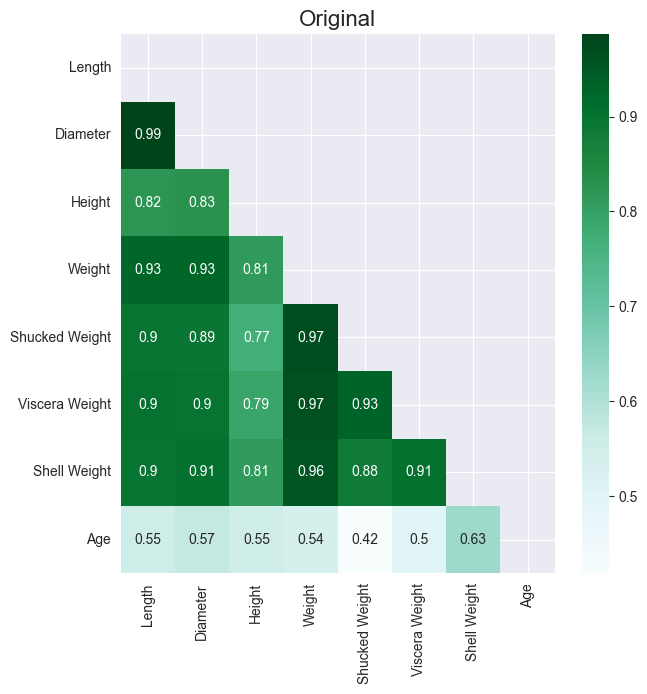

In [17]:
def show_feature_correlation(df: pd.DataFrame, title: str):
    plt.figure(figsize=(7, 7))
    corr_matrix = df.select_dtypes(include='number').corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr_matrix, cmap='BuGn', annot=True, mask=mask)
    plt.title(title, fontsize=16)
    plt.yticks(rotation=360) # I don't know why rotating by 360 as an effect of 90 degree ration, 90-degree rotation had no effect
    plt.show()

show_feature_correlation(df_train, "Train")
show_feature_correlation(df_test, "Test")
show_feature_correlation(df_og, "Original")

Diameter and Length are perfectly correlated and Weight, Shell Weigth, Viscera Weight and Shucked Weight are almost perfectly correlated.

When two or more features in a dataset are highly correlated, they can provide redundant information to the model, which does not add any additional information over the other features. This redundancy can cause instability in the model and lead to biased predictions.

Decision tree-based algorithms, such as Random Forest, LGBM and XGBoost, choose a subset of features for consideration at each node. This situation can lead to a bias towards the correlated features, which may negatively impact the model's performance.

# Data Prep

In [18]:
numerical_columns = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight', 'Age']
numerical_features = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight',]
categorical_columns = ['Sex']
target = 'Age'

In [19]:
def one_hot_encode(df: pd.DataFrame) -> pd.DataFrame:
    one_hot_encoded_data = pd.get_dummies(df, columns=categorical_columns)
    return one_hot_encoded_data

In [20]:
df_train: pd.DataFrame = pd.concat([df_train, df_og])
df_train.reset_index(inplace=True, drop=True)

In [21]:
df_train = one_hot_encode(df_train)
df_test = one_hot_encode(df_test)

In [22]:
#to_drop = ['Diameter']
#df_train = df_train.drop(to_drop, axis=1)
#df_test = df_test.drop(to_drop, axis=1)

In [23]:
df_train, df_holdout = train_test_split(df_train, test_size=0.2, random_state=1)

In [24]:
scaler = StandardScaler()
scaler.fit(df_train[numerical_features])
df_train[numerical_features] = scaler.transform(df_train[numerical_features])
df_test[numerical_features] = scaler.transform(df_test[numerical_features])
df_holdout[numerical_features] = scaler.transform(df_holdout[numerical_features])

# Train

## Hypermarket search

In [25]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'metric': 'mae',
        'objective': 'regression_l1',
        'n_estimators': 1000,
        'max_depth': trial.suggest_int('max_depth', 8, 12),
        'num_leaves': trial.suggest_int('num_leaves', 50, 250),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 0.6),
        'min_child_samples': trial.suggest_int('min_child_samples', 256, 512),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'force_col_wise': trial.suggest_categorical('force_col_wise', [True, False]),
        'subsample': 0.4,
        'verbosity': -1
    }

    # Split the data into training and validation sets
    X = df_train.drop('Age', axis=1)
    y = df_train['Age']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the LGBM regressor
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val.ravel())], verbose=False)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_lgbm = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_lgbm.optimize(objective, n_trials=50)

# Print the best parameters and the best MAE
best_params = study_lgbm.best_params
best_mae = study_lgbm.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

lgbm_param = {
    'metric': 'mae',
    'objective': 'regression_l1',
    'n_estimators': 10000,
    'max_depth': study_lgbm.best_params['max_depth'],
    'num_leaves': study_lgbm.best_params['num_leaves'],
    'learning_rate': study_lgbm.best_params['learning_rate'],
    'feature_fraction': study_lgbm.best_params['feature_fraction'],
    'min_child_samples': study_lgbm.best_params['min_child_samples'],
    'reg_alpha': study_lgbm.best_params['reg_alpha'],
    'reg_lambda': study_lgbm.best_params['reg_lambda'],
    'force_col_wise': study_lgbm.best_params['force_col_wise'],
    'subsample': 0.4,
}

[I 2023-06-11 21:21:22,320] A new study created in memory with name: no-name-3ba340b8-372f-455a-9072-6ca5180ac7ea


[LightGBM] [Warning] feature_fraction is set=0.5419603209001222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5419603209001222


[I 2023-06-11 21:21:26,828] Trial 0 finished with value: 1.3778867547880176 and parameters: {'max_depth': 12, 'num_leaves': 116, 'learning_rate': 0.06327095786281306, 'feature_fraction': 0.5419603209001222, 'min_child_samples': 315, 'reg_alpha': 9.288302897573912, 'reg_lambda': 2.6784075655855313, 'force_col_wise': False}. Best is trial 0 with value: 1.3778867547880176.


[LightGBM] [Warning] feature_fraction is set=0.46740155334409594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46740155334409594


[I 2023-06-11 21:21:30,480] Trial 1 finished with value: 1.378181817586388 and parameters: {'max_depth': 10, 'num_leaves': 179, 'learning_rate': 0.09566675905285588, 'feature_fraction': 0.46740155334409594, 'min_child_samples': 343, 'reg_alpha': 6.007156512246629, 'reg_lambda': 4.366881840034954, 'force_col_wise': True}. Best is trial 0 with value: 1.3778867547880176.


[LightGBM] [Warning] feature_fraction is set=0.40963884099297165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40963884099297165


[I 2023-06-11 21:21:33,978] Trial 2 finished with value: 1.3776896365797042 and parameters: {'max_depth': 11, 'num_leaves': 93, 'learning_rate': 0.04517290209752124, 'feature_fraction': 0.40963884099297165, 'min_child_samples': 491, 'reg_alpha': 7.233518459428728, 'reg_lambda': 0.20414712449301264, 'force_col_wise': True}. Best is trial 2 with value: 1.3776896365797042.


[LightGBM] [Warning] feature_fraction is set=0.43724590413218833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43724590413218833


[I 2023-06-11 21:21:36,528] Trial 3 finished with value: 1.3787005627727236 and parameters: {'max_depth': 9, 'num_leaves': 216, 'learning_rate': 0.043298812235644225, 'feature_fraction': 0.43724590413218833, 'min_child_samples': 417, 'reg_alpha': 1.4357987459148536, 'reg_lambda': 3.7100955016354664, 'force_col_wise': False}. Best is trial 2 with value: 1.3776896365797042.


[LightGBM] [Warning] feature_fraction is set=0.4026955164240614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4026955164240614


[I 2023-06-11 21:21:39,258] Trial 4 finished with value: 1.3800286929803738 and parameters: {'max_depth': 10, 'num_leaves': 164, 'learning_rate': 0.031212228068279058, 'feature_fraction': 0.4026955164240614, 'min_child_samples': 465, 'reg_alpha': 2.963305443345008, 'reg_lambda': 3.3091231488304973, 'force_col_wise': True}. Best is trial 2 with value: 1.3776896365797042.


[LightGBM] [Warning] feature_fraction is set=0.46869160047238784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46869160047238784


[I 2023-06-11 21:21:41,978] Trial 5 finished with value: 1.377382574973673 and parameters: {'max_depth': 8, 'num_leaves': 197, 'learning_rate': 0.09125890501694407, 'feature_fraction': 0.46869160047238784, 'min_child_samples': 439, 'reg_alpha': 2.3815972056347423, 'reg_lambda': 9.738720220556319, 'force_col_wise': False}. Best is trial 5 with value: 1.377382574973673.


[LightGBM] [Warning] feature_fraction is set=0.5336166850400165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5336166850400165


[I 2023-06-11 21:21:44,975] Trial 6 finished with value: 1.3789755516922997 and parameters: {'max_depth': 12, 'num_leaves': 83, 'learning_rate': 0.03438514141097944, 'feature_fraction': 0.5336166850400165, 'min_child_samples': 397, 'reg_alpha': 6.880183661392301, 'reg_lambda': 3.463943255861679, 'force_col_wise': False}. Best is trial 5 with value: 1.377382574973673.


[LightGBM] [Warning] feature_fraction is set=0.4833120042379601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4833120042379601


[I 2023-06-11 21:21:47,735] Trial 7 finished with value: 1.3797622587433822 and parameters: {'max_depth': 10, 'num_leaves': 95, 'learning_rate': 0.03670826567399272, 'feature_fraction': 0.4833120042379601, 'min_child_samples': 408, 'reg_alpha': 0.24304857646618494, 'reg_lambda': 6.638513082582541, 'force_col_wise': False}. Best is trial 5 with value: 1.377382574973673.


[LightGBM] [Warning] feature_fraction is set=0.5183670058506603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5183670058506603


[I 2023-06-11 21:21:51,256] Trial 8 finished with value: 1.3812877351225439 and parameters: {'max_depth': 12, 'num_leaves': 227, 'learning_rate': 0.01570555932227685, 'feature_fraction': 0.5183670058506603, 'min_child_samples': 419, 'reg_alpha': 0.13004946478010204, 'reg_lambda': 1.7965150915658323, 'force_col_wise': False}. Best is trial 5 with value: 1.377382574973673.


[LightGBM] [Warning] feature_fraction is set=0.5864174714545842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5864174714545842


[I 2023-06-11 21:21:54,069] Trial 9 finished with value: 1.379140152452298 and parameters: {'max_depth': 12, 'num_leaves': 68, 'learning_rate': 0.08451914912189808, 'feature_fraction': 0.5864174714545842, 'min_child_samples': 446, 'reg_alpha': 6.564528670639065, 'reg_lambda': 4.015325746790265, 'force_col_wise': False}. Best is trial 5 with value: 1.377382574973673.


[LightGBM] [Warning] feature_fraction is set=0.4588009708898848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4588009708898848


[I 2023-06-11 21:21:56,995] Trial 10 finished with value: 1.3751191349757161 and parameters: {'max_depth': 8, 'num_leaves': 250, 'learning_rate': 0.06771984334510028, 'feature_fraction': 0.4588009708898848, 'min_child_samples': 275, 'reg_alpha': 3.856379272807021, 'reg_lambda': 9.599851308781682, 'force_col_wise': True}. Best is trial 10 with value: 1.3751191349757161.


[LightGBM] [Warning] feature_fraction is set=0.4567910402970248, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4567910402970248


[I 2023-06-11 21:21:59,458] Trial 11 finished with value: 1.3762441821111455 and parameters: {'max_depth': 8, 'num_leaves': 248, 'learning_rate': 0.07339433905509456, 'feature_fraction': 0.4567910402970248, 'min_child_samples': 273, 'reg_alpha': 3.6707868540168325, 'reg_lambda': 9.864835158880338, 'force_col_wise': True}. Best is trial 10 with value: 1.3751191349757161.


[LightGBM] [Warning] feature_fraction is set=0.44474034904556425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44474034904556425


[I 2023-06-11 21:22:01,992] Trial 12 finished with value: 1.372985845401476 and parameters: {'max_depth': 8, 'num_leaves': 245, 'learning_rate': 0.06889897298091084, 'feature_fraction': 0.44474034904556425, 'min_child_samples': 263, 'reg_alpha': 4.066868235743748, 'reg_lambda': 9.965981346012828, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.43472649445885814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43472649445885814


[I 2023-06-11 21:22:05,195] Trial 13 finished with value: 1.3741295662373345 and parameters: {'max_depth': 9, 'num_leaves': 245, 'learning_rate': 0.06336255273426812, 'feature_fraction': 0.43472649445885814, 'min_child_samples': 264, 'reg_alpha': 4.576693520335728, 'reg_lambda': 8.074887169615307, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.42817942678767806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42817942678767806


[I 2023-06-11 21:22:08,037] Trial 14 finished with value: 1.3730545236864717 and parameters: {'max_depth': 9, 'num_leaves': 136, 'learning_rate': 0.05623815228953956, 'feature_fraction': 0.42817942678767806, 'min_child_samples': 325, 'reg_alpha': 4.936723587629256, 'reg_lambda': 8.14349628007069, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.42602355467667535, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42602355467667535


[I 2023-06-11 21:22:10,786] Trial 15 finished with value: 1.3757168026401918 and parameters: {'max_depth': 9, 'num_leaves': 135, 'learning_rate': 0.05359493796944792, 'feature_fraction': 0.42602355467667535, 'min_child_samples': 348, 'reg_alpha': 5.256577145041106, 'reg_lambda': 5.998874351202005, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.4930785321867601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4930785321867601


[I 2023-06-11 21:22:13,426] Trial 16 finished with value: 1.3776614730429602 and parameters: {'max_depth': 9, 'num_leaves': 141, 'learning_rate': 0.08065614917000191, 'feature_fraction': 0.4930785321867601, 'min_child_samples': 306, 'reg_alpha': 4.832584252493819, 'reg_lambda': 7.986783594506536, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.400494758379736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.400494758379736


[I 2023-06-11 21:22:15,796] Trial 17 finished with value: 1.3757864025898912 and parameters: {'max_depth': 8, 'num_leaves': 50, 'learning_rate': 0.05552353647996836, 'feature_fraction': 0.400494758379736, 'min_child_samples': 356, 'reg_alpha': 3.2635267841115, 'reg_lambda': 8.352534108942619, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.4346716928652813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4346716928652813


[I 2023-06-11 21:22:18,493] Trial 18 finished with value: 1.374218164235069 and parameters: {'max_depth': 9, 'num_leaves': 168, 'learning_rate': 0.07186877068674774, 'feature_fraction': 0.4346716928652813, 'min_child_samples': 304, 'reg_alpha': 2.035198298354949, 'reg_lambda': 5.82452867301919, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.44752915428402484, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44752915428402484


[I 2023-06-11 21:22:21,729] Trial 19 finished with value: 1.374514404901923 and parameters: {'max_depth': 11, 'num_leaves': 127, 'learning_rate': 0.05595969669225682, 'feature_fraction': 0.44752915428402484, 'min_child_samples': 373, 'reg_alpha': 4.215896742569319, 'reg_lambda': 7.279182369031827, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.42489675760371626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42489675760371626


[I 2023-06-11 21:22:24,039] Trial 20 finished with value: 1.3735775005679185 and parameters: {'max_depth': 8, 'num_leaves': 113, 'learning_rate': 0.07871132945384181, 'feature_fraction': 0.42489675760371626, 'min_child_samples': 323, 'reg_alpha': 5.592175696721153, 'reg_lambda': 8.890647473482616, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.42190894424589676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42190894424589676


[I 2023-06-11 21:22:26,968] Trial 21 finished with value: 1.3757024031064888 and parameters: {'max_depth': 8, 'num_leaves': 153, 'learning_rate': 0.0770809177725061, 'feature_fraction': 0.42190894424589676, 'min_child_samples': 326, 'reg_alpha': 5.392857808301872, 'reg_lambda': 8.827266785305127, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.41827641788611614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41827641788611614


[I 2023-06-11 21:22:29,555] Trial 22 finished with value: 1.3740909156563328 and parameters: {'max_depth': 8, 'num_leaves': 111, 'learning_rate': 0.08847920618381606, 'feature_fraction': 0.41827641788611614, 'min_child_samples': 286, 'reg_alpha': 5.519544089257123, 'reg_lambda': 9.076995734761107, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.4448948927444823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4448948927444823


[I 2023-06-11 21:22:32,345] Trial 23 finished with value: 1.375081040410706 and parameters: {'max_depth': 9, 'num_leaves': 191, 'learning_rate': 0.08088632368698721, 'feature_fraction': 0.4448948927444823, 'min_child_samples': 293, 'reg_alpha': 4.159918624332724, 'reg_lambda': 7.279864974596739, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.41887769302274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41887769302274


[I 2023-06-11 21:22:35,460] Trial 24 finished with value: 1.37467552577536 and parameters: {'max_depth': 8, 'num_leaves': 121, 'learning_rate': 0.09916574103890671, 'feature_fraction': 0.41887769302274, 'min_child_samples': 327, 'reg_alpha': 6.069803647112528, 'reg_lambda': 9.994738746334686, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.44559316532165505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44559316532165505


[I 2023-06-11 21:22:38,686] Trial 25 finished with value: 1.3753754407137038 and parameters: {'max_depth': 9, 'num_leaves': 154, 'learning_rate': 0.07152316188197913, 'feature_fraction': 0.44559316532165505, 'min_child_samples': 372, 'reg_alpha': 4.912916536367944, 'reg_lambda': 8.588223855730744, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.47787619740543924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47787619740543924


[I 2023-06-11 21:22:42,739] Trial 26 finished with value: 1.3766290313653782 and parameters: {'max_depth': 8, 'num_leaves': 104, 'learning_rate': 0.08428974683689297, 'feature_fraction': 0.47787619740543924, 'min_child_samples': 261, 'reg_alpha': 3.360640416073937, 'reg_lambda': 9.15670906606037, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.4272392464619046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4272392464619046


[I 2023-06-11 21:22:47,669] Trial 27 finished with value: 1.3744025614286717 and parameters: {'max_depth': 9, 'num_leaves': 205, 'learning_rate': 0.06487809208891195, 'feature_fraction': 0.4272392464619046, 'min_child_samples': 291, 'reg_alpha': 7.76021204509145, 'reg_lambda': 7.622905738876989, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.4535442281617787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4535442281617787


[I 2023-06-11 21:22:51,661] Trial 28 finished with value: 1.3762688645777779 and parameters: {'max_depth': 8, 'num_leaves': 140, 'learning_rate': 0.07552498030251598, 'feature_fraction': 0.4535442281617787, 'min_child_samples': 324, 'reg_alpha': 4.372490823887958, 'reg_lambda': 8.931004342091253, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.414895190682422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.414895190682422


[I 2023-06-11 21:22:56,288] Trial 29 finished with value: 1.3769502588846143 and parameters: {'max_depth': 9, 'num_leaves': 119, 'learning_rate': 0.06200263943723845, 'feature_fraction': 0.414895190682422, 'min_child_samples': 344, 'reg_alpha': 8.597970614730285, 'reg_lambda': 8.304116365021436, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.5017746805846891, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5017746805846891


[I 2023-06-11 21:23:01,141] Trial 30 finished with value: 1.3767309600344932 and parameters: {'max_depth': 10, 'num_leaves': 75, 'learning_rate': 0.06779724396761508, 'feature_fraction': 0.5017746805846891, 'min_child_samples': 318, 'reg_alpha': 5.873268152892965, 'reg_lambda': 9.339740232354387, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.4150132369153547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4150132369153547


[I 2023-06-11 21:23:05,473] Trial 31 finished with value: 1.3743941456297435 and parameters: {'max_depth': 8, 'num_leaves': 108, 'learning_rate': 0.08929052862950206, 'feature_fraction': 0.4150132369153547, 'min_child_samples': 286, 'reg_alpha': 4.998650342093647, 'reg_lambda': 9.335793429518802, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.4000651053628258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4000651053628258


[I 2023-06-11 21:23:09,842] Trial 32 finished with value: 1.3745682200440614 and parameters: {'max_depth': 8, 'num_leaves': 104, 'learning_rate': 0.07769128806135638, 'feature_fraction': 0.4000651053628258, 'min_child_samples': 259, 'reg_alpha': 5.571047179798674, 'reg_lambda': 8.981798154600494, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.4302062830369304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4302062830369304


[I 2023-06-11 21:23:13,814] Trial 33 finished with value: 1.374344552047912 and parameters: {'max_depth': 8, 'num_leaves': 129, 'learning_rate': 0.09210229427979826, 'feature_fraction': 0.4302062830369304, 'min_child_samples': 302, 'reg_alpha': 5.89005973165158, 'reg_lambda': 9.986585336315734, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.4151951483267316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151951483267316


[I 2023-06-11 21:23:17,866] Trial 34 finished with value: 1.3750200583995038 and parameters: {'max_depth': 8, 'num_leaves': 114, 'learning_rate': 0.08653092070678087, 'feature_fraction': 0.4151951483267316, 'min_child_samples': 278, 'reg_alpha': 6.559551017365552, 'reg_lambda': 8.567821893467396, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.44015021546659067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44015021546659067


[I 2023-06-11 21:23:22,038] Trial 35 finished with value: 1.3761635114104245 and parameters: {'max_depth': 9, 'num_leaves': 89, 'learning_rate': 0.09497849708230202, 'feature_fraction': 0.44015021546659067, 'min_child_samples': 334, 'reg_alpha': 5.3111283182645765, 'reg_lambda': 7.756731125074974, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.40952854606838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40952854606838


[I 2023-06-11 21:23:25,770] Trial 36 finished with value: 1.3742294299536006 and parameters: {'max_depth': 8, 'num_leaves': 164, 'learning_rate': 0.08113464884009457, 'feature_fraction': 0.40952854606838, 'min_child_samples': 358, 'reg_alpha': 4.626524330957256, 'reg_lambda': 9.065594954301014, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.46596483786127707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46596483786127707


[I 2023-06-11 21:23:30,570] Trial 37 finished with value: 1.3772331172680814 and parameters: {'max_depth': 10, 'num_leaves': 180, 'learning_rate': 0.08634958592965135, 'feature_fraction': 0.46596483786127707, 'min_child_samples': 311, 'reg_alpha': 7.515842179910811, 'reg_lambda': 9.493994577516206, 'force_col_wise': False}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.4283711250819199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4283711250819199


[I 2023-06-11 21:23:34,882] Trial 38 finished with value: 1.3768623492057155 and parameters: {'max_depth': 11, 'num_leaves': 145, 'learning_rate': 0.09800035967211147, 'feature_fraction': 0.4283711250819199, 'min_child_samples': 510, 'reg_alpha': 4.015269672254633, 'reg_lambda': 7.2096171558947795, 'force_col_wise': True}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.4397395540595197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4397395540595197


[I 2023-06-11 21:23:39,545] Trial 39 finished with value: 1.3739816361796011 and parameters: {'max_depth': 9, 'num_leaves': 219, 'learning_rate': 0.06002140617961032, 'feature_fraction': 0.4397395540595197, 'min_child_samples': 291, 'reg_alpha': 6.217869772741885, 'reg_lambda': 8.477310123846186, 'force_col_wise': False}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.43855342599175356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43855342599175356


[I 2023-06-11 21:23:44,302] Trial 40 finished with value: 1.3755477287055262 and parameters: {'max_depth': 9, 'num_leaves': 238, 'learning_rate': 0.05971117065815928, 'feature_fraction': 0.43855342599175356, 'min_child_samples': 256, 'reg_alpha': 6.161768795940403, 'reg_lambda': 8.397678705068326, 'force_col_wise': False}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.4104570406585241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4104570406585241


[I 2023-06-11 21:23:49,699] Trial 41 finished with value: 1.375128391140145 and parameters: {'max_depth': 10, 'num_leaves': 228, 'learning_rate': 0.05133207014469108, 'feature_fraction': 0.4104570406585241, 'min_child_samples': 289, 'reg_alpha': 6.909896804756388, 'reg_lambda': 9.445566121726323, 'force_col_wise': False}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.45111715512191797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45111715512191797


[I 2023-06-11 21:23:53,948] Trial 42 finished with value: 1.3759152032517283 and parameters: {'max_depth': 8, 'num_leaves': 215, 'learning_rate': 0.06781992994735118, 'feature_fraction': 0.45111715512191797, 'min_child_samples': 276, 'reg_alpha': 5.621062826409498, 'reg_lambda': 8.716072961092674, 'force_col_wise': False}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.42273153156679827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42273153156679827


[I 2023-06-11 21:23:58,330] Trial 43 finished with value: 1.3732360157287542 and parameters: {'max_depth': 8, 'num_leaves': 224, 'learning_rate': 0.049083334900672806, 'feature_fraction': 0.42273153156679827, 'min_child_samples': 297, 'reg_alpha': 6.370643397203796, 'reg_lambda': 7.895382720465233, 'force_col_wise': False}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.460024381833055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.460024381833055


[I 2023-06-11 21:24:03,170] Trial 44 finished with value: 1.376273030992872 and parameters: {'max_depth': 10, 'num_leaves': 227, 'learning_rate': 0.04804653817123724, 'feature_fraction': 0.460024381833055, 'min_child_samples': 337, 'reg_alpha': 6.4394712839928525, 'reg_lambda': 7.9356516440231655, 'force_col_wise': False}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.436504171451464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.436504171451464


[I 2023-06-11 21:24:08,022] Trial 45 finished with value: 1.3740853334664949 and parameters: {'max_depth': 9, 'num_leaves': 216, 'learning_rate': 0.05940147659847365, 'feature_fraction': 0.436504171451464, 'min_child_samples': 301, 'reg_alpha': 7.076136103655634, 'reg_lambda': 6.946660147783454, 'force_col_wise': False}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.442841662941601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.442841662941601


[I 2023-06-11 21:24:11,372] Trial 46 finished with value: 1.3744474849832955 and parameters: {'max_depth': 8, 'num_leaves': 240, 'learning_rate': 0.045904454037076166, 'feature_fraction': 0.442841662941601, 'min_child_samples': 315, 'reg_alpha': 6.279613050520849, 'reg_lambda': 6.554994911003978, 'force_col_wise': False}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.42742124282772326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42742124282772326


[I 2023-06-11 21:24:14,234] Trial 47 finished with value: 1.3793817972124403 and parameters: {'max_depth': 9, 'num_leaves': 202, 'learning_rate': 0.03904527355290506, 'feature_fraction': 0.42742124282772326, 'min_child_samples': 396, 'reg_alpha': 5.063212966626018, 'reg_lambda': 8.116515845976668, 'force_col_wise': False}. Best is trial 12 with value: 1.372985845401476.


[LightGBM] [Warning] feature_fraction is set=0.40646372552678894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40646372552678894


[I 2023-06-11 21:24:18,445] Trial 48 finished with value: 1.3727836904791755 and parameters: {'max_depth': 10, 'num_leaves': 216, 'learning_rate': 0.058640504567434096, 'feature_fraction': 0.40646372552678894, 'min_child_samples': 272, 'reg_alpha': 4.6259195092106635, 'reg_lambda': 9.676919030175227, 'force_col_wise': False}. Best is trial 48 with value: 1.3727836904791755.


[LightGBM] [Warning] feature_fraction is set=0.40696483240179276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40696483240179276


[I 2023-06-11 21:24:21,638] Trial 49 finished with value: 1.3737730070437961 and parameters: {'max_depth': 10, 'num_leaves': 188, 'learning_rate': 0.0506675847213645, 'feature_fraction': 0.40696483240179276, 'min_child_samples': 268, 'reg_alpha': 3.788305529998887, 'reg_lambda': 9.601008614744492, 'force_col_wise': False}. Best is trial 48 with value: 1.3727836904791755.


Best Parameters: {'max_depth': 10, 'num_leaves': 216, 'learning_rate': 0.058640504567434096, 'feature_fraction': 0.40646372552678894, 'min_child_samples': 272, 'reg_alpha': 4.6259195092106635, 'reg_lambda': 9.676919030175227, 'force_col_wise': False}
Best MAE: 1.3727836904791755


In [26]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'loss_function': 'MAE',
        'depth': trial.suggest_int('depth', 3, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0, 1),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'iterations': 1000,
        'early_stopping_rounds': 100,
        'verbose': False
    }

    # Split the data into training and validation sets
    X = df_train.drop('Age', axis=1)
    y = df_train['Age']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the CatBoost regressor
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val))

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_catboost = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_catboost.optimize(objective, n_trials=25)

# Print the best parameters and the best MAE
best_params = study_catboost.best_params
best_mae = study_catboost.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

cat_param = {        'loss_function': 'MAE',
                     'depth': study_catboost.best_params['depth'],
                     'learning_rate': study_catboost.best_params['learning_rate'],
                     'l2_leaf_reg': study_catboost.best_params['l2_leaf_reg'],
                     'random_strength': study_catboost.best_params['random_strength'],
                     'bagging_temperature': study_catboost.best_params['bagging_temperature'],
                     'grow_policy': study_catboost.best_params['grow_policy'],
                     'iterations': 5000,
                     'early_stopping_rounds': 100,
                     'verbose': False}

[I 2023-06-11 21:24:21,653] A new study created in memory with name: no-name-138c04ea-477e-4a27-b293-01903e817de9
[I 2023-06-11 21:24:28,485] Trial 0 finished with value: 1.381045135182012 and parameters: {'depth': 7, 'learning_rate': 0.08318305017339014, 'l2_leaf_reg': 0.5444628654300386, 'random_strength': 0.8030332616362595, 'bagging_temperature': 0.43442881920821685, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 1.381045135182012.
[I 2023-06-11 21:24:36,048] Trial 1 finished with value: 1.376104065070232 and parameters: {'depth': 5, 'learning_rate': 0.14151025449292218, 'l2_leaf_reg': 0.41402601678404294, 'random_strength': 0.7441075511219843, 'bagging_temperature': 0.8684059682702915, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 1.376104065070232.
[I 2023-06-11 21:24:41,660] Trial 2 finished with value: 1.3816481254273048 and parameters: {'depth': 8, 'learning_rate': 0.08533862814260652, 'l2_leaf_reg': 0.5899686394438174, 'random_strength': 0.91536818685

Best Parameters: {'depth': 10, 'learning_rate': 0.017041892987962205, 'l2_leaf_reg': 0.9490608761916478, 'random_strength': 0.5145394728443956, 'bagging_temperature': 0.28452317135969446, 'grow_policy': 'Depthwise'}
Best MAE: 1.3717362291331006


In [27]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'C': trial.suggest_float('C', 0.01, 100.0),
        'epsilon': trial.suggest_float('epsilon', 0.01, 1.0),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf'])
    }

    # Split the data into training and validation sets
    X = df_train.drop('Age', axis=1)
    y = df_train['Age']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the SVR model
    model = SVR(**params)
    model.fit(X_train, y_train)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_svr = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_svr.optimize(objective, n_trials=15)

# Print the best parameters and the best MAE
best_params = study_svr.best_params
best_mae = study_svr.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

svr_param = {
    'C': study_svr.best_params['C'],
    'epsilon': study_svr.best_params['epsilon'],
    'kernel': study_svr.best_params['kernel']
}

[I 2023-06-11 21:46:11,096] A new study created in memory with name: no-name-298bd9be-8d42-424c-91b5-ab6202e797ac
[I 2023-06-11 21:48:49,352] Trial 0 finished with value: 1.4655059141917992 and parameters: {'C': 4.913807399160999, 'epsilon': 0.17060035047409824, 'kernel': 'linear'}. Best is trial 0 with value: 1.4655059141917992.
[I 2023-06-11 22:01:08,212] Trial 1 finished with value: 1.4659386147899884 and parameters: {'C': 59.5530537029524, 'epsilon': 0.5321172116888943, 'kernel': 'linear'}. Best is trial 0 with value: 1.4655059141917992.
[I 2023-06-11 22:02:31,477] Trial 2 finished with value: 1.3983989516851822 and parameters: {'C': 34.98310961587228, 'epsilon': 0.6435574591015011, 'kernel': 'rbf'}. Best is trial 2 with value: 1.3983989516851822.
[I 2023-06-11 22:06:00,058] Trial 3 finished with value: 1.4046457788869433 and parameters: {'C': 14.918016861429255, 'epsilon': 0.5120935264350853, 'kernel': 'poly'}. Best is trial 2 with value: 1.3983989516851822.
[I 2023-06-11 22:10:56

Best Parameters: {'C': 24.948296832035467, 'epsilon': 0.08193672403145451, 'kernel': 'rbf'}
Best MAE: 1.395662102184406


In [28]:
xgb_param = {
    'n_estimators': 5000,
    'learning_rate': 0.00482382842096919,
    'booster': 'gbtree',
    'lambda': 0.000235366507474591,
    'alpha': 0.0000115977765684837,
    'subsample': 0.35955930593108,
    'colsample_bytree': 0.898528184386095,
    'max_depth': 9,
    'min_child_weight': 8,
    'eta': 0.0000784943239744148,
    'gamma': 1.6661346939401E-07,
    'grow_policy': 'lossguide',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0,
}

In [29]:
gbr_params = {
    'loss': 'absolute_error',
    'n_estimators': 500,
    'max_depth': 10,
    'learning_rate': 0.01,
    'min_samples_split': 20,
    'min_samples_leaf': 30
}

## Train models with found hyperspaces

In [30]:
class Pipeline:

    def __init__(self, model_type: str):
        self.model_type = model_type
        if model_type == 'LightGBM':
            self.model = lgb.LGBMRegressor(**lgbm_param)
        elif model_type == 'CatBoost':
            self.model = CatBoostRegressor(**cat_param)
        elif model_type == 'XGBoost':
            self.model = XGBRegressor(**xgb_param)
        elif model_type == 'GBR':
            raise ValueError(f'{model_type} is very slow ): dont use it!')
            #self.model = GradientBoostingRegressor(**gbr_params)
        elif model_type == 'SVR':
            self.model = SVR(**svr_param)
        else:
            raise ValueError(f"Given model type is not supported! {model_type} was given.")

    def fit(self, X, y, X_val, y_val):
        if self.model_type in ['GBR', 'SVR']:
            self.model.fit(X, y.ravel())
        else:
            self.model.fit(X, y.ravel(), eval_set=[(X_val, y_val.ravel())], early_stopping_rounds=250, verbose=False)

    def predict(self, X):
        return self.model.predict(X)

In [31]:
def train(model_type):
    X = df_train.drop(['Age'], axis=1)
    y = df_train['Age']
    SKFs = KFold(n_splits=10, shuffle=True, random_state=1)
    losses = []
    pipelines = []
    idx_vls = []
    for fold, (idx_tr, idx_vl) in enumerate(SKFs.split(X, y)):
        train_dataframe = df_train.iloc[idx_tr]
        dev_dataframe = df_train.iloc[idx_vl]

        # splits data to features and target
        X_train = train_dataframe.drop('Age', axis=1)
        y_train = train_dataframe['Age']
        X_dev = dev_dataframe.drop('Age', axis=1)
        y_dev = dev_dataframe['Age']

        # crates and fits a pipeline
        pipelineMy = Pipeline(model_type)
        pipelineMy.fit(X_train, y_train, X_dev, y_dev)

        # evaluates the model
        pipelines.append(pipelineMy)
        loss = mean_absolute_error(y_dev, pipelineMy.predict(X_dev))
        losses.append(loss)
        idx_vls.append(idx_vl)
        print(f'Fold {fold} loss: {loss}')
    print(f'Mean loss: {np.array(losses).mean()}')
    return losses, pipelines, idx_vls

In [32]:
supported_models = ['LightGBM', 'CatBoost', 'XGBoost', 'SVR'] #'GBR'

In [33]:
train_results = {}
for model_name in supported_models:
    print(f"-------------------- {model_name} -------------------- ")
    losses, pipelines, eval_sets = train(model_name)
    train_results[f'{model_name}_losses'] = losses
    train_results[f'{model_name}_pipelines'] = pipelines
    train_results[f'{model_name}_eval_sets'] = eval_sets

C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


-------------------- LightGBM -------------------- 
[LightGBM] [Warning] feature_fraction is set=0.40646372552678894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40646372552678894
Fold 0 loss: 1.3500501504750508
[LightGBM] [Warning] feature_fraction is set=0.40646372552678894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40646372552678894


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 loss: 1.3841688443141782
[LightGBM] [Warning] feature_fraction is set=0.40646372552678894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40646372552678894


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 loss: 1.3374770916310916
[LightGBM] [Warning] feature_fraction is set=0.40646372552678894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40646372552678894


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 loss: 1.347588783421431
[LightGBM] [Warning] feature_fraction is set=0.40646372552678894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40646372552678894


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 4 loss: 1.3455453030249371
[LightGBM] [Warning] feature_fraction is set=0.40646372552678894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40646372552678894


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 5 loss: 1.3556150560278295
[LightGBM] [Warning] feature_fraction is set=0.40646372552678894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40646372552678894


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 6 loss: 1.3673255512362124
[LightGBM] [Warning] feature_fraction is set=0.40646372552678894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40646372552678894


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 7 loss: 1.3698463517647386
[LightGBM] [Warning] feature_fraction is set=0.40646372552678894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40646372552678894


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 8 loss: 1.3615453471954084
[LightGBM] [Warning] feature_fraction is set=0.40646372552678894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40646372552678894


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 9 loss: 1.387419772971941
Mean loss: 1.3606582252062818
-------------------- CatBoost -------------------- 
Fold 0 loss: 1.3507172889281127
Fold 1 loss: 1.3753416508403704
Fold 2 loss: 1.3326965170816674
Fold 3 loss: 1.3452145089688645
Fold 4 loss: 1.3422962793502002
Fold 5 loss: 1.3501329278116383
Fold 6 loss: 1.3685075412907428
Fold 7 loss: 1.3697635451891153
Fold 8 loss: 1.3600820218749745
Fold 9 loss: 1.386866369506815
Mean loss: 1.3581618650842502
-------------------- XGBoost -------------------- 


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 0 loss: 1.3621427193905316


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 loss: 1.3862552898216125


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 loss: 1.3428946424172887


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 loss: 1.3608088180986715


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 loss: 1.358610255049925


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 5 loss: 1.3687097648859214


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 6 loss: 1.3820636995142712


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 7 loss: 1.3842248293334423


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 8 loss: 1.3773026924087415


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 9 loss: 1.3976635690871104
Mean loss: 1.3720676280007518
-------------------- SVR -------------------- 
Fold 0 loss: 1.382555472853518
Fold 1 loss: 1.3957033325692736
Fold 2 loss: 1.351012762848639
Fold 3 loss: 1.3701911425243853
Fold 4 loss: 1.3677445877282917
Fold 5 loss: 1.3723105006351817
Fold 6 loss: 1.393481229128121
Fold 7 loss: 1.3945580342977515
Fold 8 loss: 1.3833771282978038
Fold 9 loss: 1.4100178555489267
Mean loss: 1.3820952046431891


# Assembly

In [34]:
df_assembly = pd.DataFrame({})

def make_model_predictions(model_name, X):
    prediction = 0
    for pipeline in train_results[f'{model_name}_pipelines']:
        prediction += pipeline.predict(X)
    return prediction / float(len(train_results[f'{model_name}_pipelines']))

for model_name in supported_models:
    X = df_holdout.drop(target, axis=1)
    df_assembly[model_name] = make_model_predictions(model_name, X)

## Simple weighted assembly

In [35]:
def eval_assembly_on_validation(weights):
    prediction = 0
    for model_id, x in enumerate(df_assembly.columns.values):
        prediction += df_assembly[x] * weights[model_id]

    return mean_absolute_error(df_holdout[target], prediction)

In [36]:
# Set initial weights
model_weights = np.array([1/len(df_assembly.columns.values) for i in range(len(df_assembly.columns.values))])
# Define the optimization bounds
bounds = [(0, 1.0)] * len(model_weights)

# Define the optimization function
res = minimize(eval_assembly_on_validation, model_weights, method='nelder-mead', bounds=bounds)
# Print the optimized weights
optimal_model_weights = res.x
print(optimal_model_weights.sum())
optimal_model_weights = optimal_model_weights / np.sum(optimal_model_weights, axis=0, keepdims=True)
print(optimal_model_weights.sum())

0.9997696476781701
1.0


In [37]:
df_optimal_model_weights = {'model_name': [], 'weight': []}
for i in range(len(df_assembly.columns.values)):
    df_optimal_model_weights['model_name'].append(df_assembly.columns.values[i])
    df_optimal_model_weights['weight'].append(optimal_model_weights[i])
    print(f"{optimal_model_weights[i]:.3f} {df_assembly.columns.values[i]}")
df_optimal_model_weights = pd.DataFrame(df_optimal_model_weights)

0.365 LightGBM
0.635 CatBoost
0.000 XGBoost
0.000 SVR


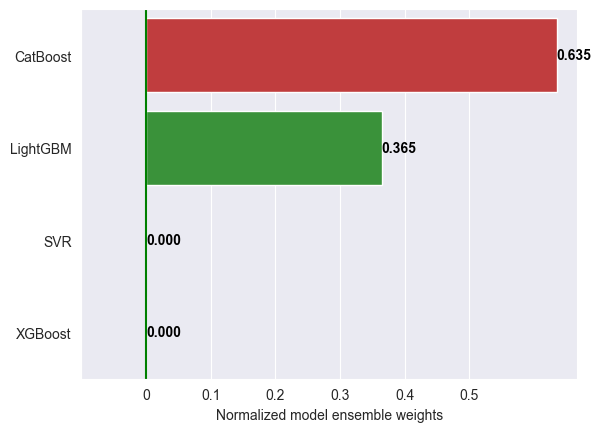

In [38]:
df_optimal_model_weights.sort_values('weight', ascending=True, inplace=True)
ax = sns.barplot(x='weight', y='model_name', data=df_optimal_model_weights, palette=sns.color_palette("tab10"))
ax.set_ylim(ax.get_ylim()[::-1])
for i, v in enumerate(df_optimal_model_weights['weight']):
    ax.text(v, i, '{:.3f}'.format(v), color='black', fontweight='bold', ha='left', va='center')
ax.set(ylabel=None)
ax.set(xlabel="Normalized model ensemble weights")
ax.set_xlim([-0.1, None])
ax.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_xticklabels(['', 0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.axvline(x=0, color='g', linestyle='-')
plt.show()

In [39]:
def make_weighted_assembly_predictions(X):
    df_tmp = pd.DataFrame({})
    for model_name in supported_models:
        df_tmp[model_name] = make_model_predictions(model_name, X)
    prediction = 0
    for model_id, x in enumerate(df_assembly.columns.values):
        prediction += df_tmp[x] * optimal_model_weights[model_id]
    return prediction

In [40]:
print(mean_absolute_error(df_holdout[target], make_weighted_assembly_predictions(df_holdout.drop(target, axis=1))))

1.3538863483611907


## Stacked assembly

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df_assembly, df_holdout[target], test_size=0.2, random_state=1)
lgbm_blender_model = lgb.LGBMRegressor(**lgbm_param)
lgbm_blender_model.fit(X_train, y_train, eval_set=[(X_test, y_test.ravel())], verbose=False)
print(mean_absolute_error(y_test, lgbm_blender_model.predict(X_test)))

[LightGBM] [Warning] feature_fraction is set=0.40646372552678894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40646372552678894
1.3319600723192901


In [42]:
def make_stacked_predictions(X):
    df_tmp = pd.DataFrame({})
    for model_name in supported_models:
        df_tmp[model_name] = make_model_predictions(model_name, X)
    return lgbm_blender_model.predict(df_tmp)

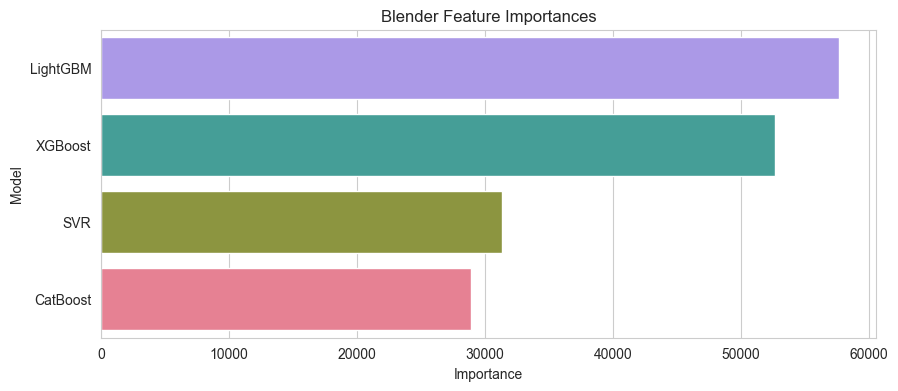

In [43]:
df_importance = pd.DataFrame({'feature': df_assembly.columns.values, 'importance': lgbm_blender_model.feature_importances_})
df_importance = df_importance.sort_values('importance', ascending=False)

sns.set_style("whitegrid")
plt.figure(figsize=(10, 4))
palette = sns.color_palette("husl", len(df_importance))
palette.reverse()
sns.barplot(x="importance", y="feature", data=df_importance, palette=palette)
plt.title('Blender Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Model')
plt.show()

# Models evaluation

In [ ]:
performance_data = {'model_name': [], 'loss_og': [], 'loss_given': [], 'loss_joined': []}

def make_model_predictions(model_name, X):
    prediction = 0
    for pipeline in train_results[f'{model_name}_pipelines']:
        prediction += pipeline.predict(X)
    return prediction / float(len(train_results[f'{model_name}_pipelines']))

df_holdout_og = df_holdout[df_holdout.index >= 74051]
df_holdout_given = df_holdout[df_holdout.index < 74051]
X_og = df_holdout_og.drop(target, axis=1)
y_og = df_holdout_og[target]
X_given = df_holdout_given.drop(target, axis=1)
y_given = df_holdout_given[target]
X_joined = df_holdout.drop(target, axis=1)
y_joined = df_holdout[target]

for model_name in supported_models:
    performance_data['model_name'].append(model_name)
    performance_data['loss_og'].append(mean_absolute_error(y_og, make_model_predictions(model_name, X_og)))
    performance_data['loss_given'].append(mean_absolute_error(y_given, make_model_predictions(model_name, X_given)))
    performance_data['loss_joined'].append(mean_absolute_error(y_joined, make_model_predictions(model_name, X_joined)))

performance_data['model_name'].append('LGBM Stacking')
performance_data['loss_og'].append(mean_absolute_error(y_og, make_stacked_predictions(X_og)))
performance_data['loss_given'].append(mean_absolute_error(y_given, make_stacked_predictions(X_given)))
performance_data['loss_joined'].append(mean_absolute_error(y_joined, make_stacked_predictions(X_joined)))

performance_data['model_name'].append('Weighted Assembly')
performance_data['loss_og'].append(mean_absolute_error(y_og, make_weighted_assembly_predictions(X_og)))
performance_data['loss_given'].append(mean_absolute_error(y_given, make_weighted_assembly_predictions(X_given)))
performance_data['loss_joined'].append(mean_absolute_error(y_joined, make_weighted_assembly_predictions(X_joined)))

performance_data = pd.DataFrame(performance_data)

In [ ]:
def graph_model_performance(loss: str, title:str, ax):
    sns.barplot(x=loss, y='model_name', data=performance_data, ax=ax, palette=palette_reversed)
    ax.set_xlim(left=1)
    for i, v in enumerate(performance_data[loss]):
        ax.text(v - 0.003, i, '{:.3f}'.format(v), color='black', fontweight='bold', ha='right', va='center')
    ax.set(ylabel=None)
    ax.set(xlabel="MAE")
    ax.set_title(title)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 9))
fig.subplots_adjust(hspace=0.5)
axes = axes.flatten()

palette = sns.color_palette("husl", n_colors=len(performance_data))
palette_reversed = palette[::-1]

performance_data.sort_values('loss_og', ascending=True, inplace=True)
graph_model_performance('loss_og', 'Loss on Original Dataset', axes[0])
performance_data.sort_values('loss_given', ascending=True, inplace=True)
graph_model_performance('loss_given', 'Loss on Given Dataset', axes[1])
performance_data.sort_values('loss_joined', ascending=True, inplace=True)
graph_model_performance('loss_joined', 'Loss on Given + Original Dataset', axes[2])
plt.show()

In [ ]:
importance = train_results['LightGBM_pipelines'][0].model.feature_importances_
for i in range(1, len(train_results['LightGBM_pipelines'])):
    importance += train_results['LightGBM_pipelines'][i].model.feature_importances_
importance = importance / 5.0
feature_names = df_train.drop('Age', axis=1).columns.values
df_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
df_importance = df_importance.sort_values('importance', ascending=False)


sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))
palette = sns.color_palette("husl", len(df_importance))
palette.reverse()
sns.barplot(x="importance", y="feature", data=df_importance, palette=palette)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
graph_data = {
    "data": [(X_given, y_given), (X_og, y_og)],
    "name": ['given', 'original']
}

sns.set_palette([sns.color_palette("tab10")[0], sns.color_palette("tab10")[2]])
for data, name in zip(graph_data['data'], graph_data['name']):
    y = data[1]
    y_predicted = make_stacked_predictions(data[0])
    data_to_graph = pd.DataFrame({"Predicted": y_predicted, "True": y})
    sns.scatterplot(x='Predicted', y='True', label=f"Belong to {name}", data=data_to_graph)

plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='red')
plt.title("True vs Predicted")
plt.legend()
plt.show()

# Make predictions

In [ ]:
#predictions = make_weighted_assembly_predictions(df_test)
predictions = make_stacked_predictions(df_test)

In [ ]:
df_sub = pd.DataFrame({'id': df_test.index, 'Age': predictions})
df_sub['Age'] = df_sub['Age'].round().astype(int)

In [ ]:
df_sub

In [ ]:
df_sub.to_csv("submission.csv", index=False)